In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import nuflux
import pandas as pd
import imageio
import uproot
import itertools
import SNeATLAS
from varname import nameof

### Set up some necessary distributions and get necessary variables for manual weighting

Conditions: 
- rock, density is 2.6 g/cm3
- muon nu only, CC interaction

In [7]:
rock_density = 2.6 #g/cm3

In [101]:
da = 0.212 / 1.2
db = (0.251e-3)/1.2
NA = 6.022e23

def max_col_len_mu(energy): #this is in CM!!!
    return (1/db)*np.log(1+energy*(db/da)) / rock_density * 100

CS = SNeATLAS.make_crossSections()
#CS.get_cs_nu_mu_cc_iso(energy)

SNe_2n_D1_0_s20 = SNeATLAS.make_SNeEvent(detMass=4e6,
                    flux_filename='ModelTemplates/SNHEMM/IIn/FinalFluxs20.dat')
SNe = SNe_2n_D1_0_s20
TIdN = SNe.get_timeIntegrated_dN_neutrino_dE_timerange(1e7) * (1/(4*np.pi*3.08567758128e20**2)) * (1/6) #custom time range!
energy_array = SNe.Energy_array[0]

total_events = SNeATLAS.integrate_logspace(energy_array, TIdN, 1e2, 1e6)[0] #units of 1/m2 (so it's total events per unit area)

In [20]:
def p_interaction(nsigma, energy): 
    return 1-np.exp(-nsigma * max_col_len_mu(energy) )

def p_depth(l, nsigma, energy): 
    function = np.exp(-nsigma * l )
    normalization = nsigma / p_interaction(nsigma, energy)
    return function*normalization

### Walk-through for single Example

In [102]:
sample_energy = 10000
col_length = np.random.rand() *  max_col_len_mu(sample_energy)
print("col length: " + str(col_length) + " cm")

col length: 360998.19612722035 cm


In [88]:
nsigma = rock_density * NA * CS.get_cs_nu_mu_cc_iso(sample_energy)

In [89]:
p_interaction(nsigma, sample_energy)

3.396432354463297e-05

In [90]:
p_depth(col_length, nsigma, sample_energy)

2.130590793867877e-06

In [178]:
def weight_manual(energy):

    outstanding_gen_probs = (1/(np.pi*50**2)) * 100000 #conditions from the MC generation
    # injection radius 50 m, number of injected events
    outstanding_phys_probs = p_interaction(nsigma, energy) * (total_events)

    weight = outstanding_phys_probs / outstanding_gen_probs
    return weight

### Comparison with leptoninjector MC

Get the weights from the already propagated and weigted muons. Take those same positions, etc. and calculate the manual weights

In [179]:
names = ['Enu','Ex','El','Plx','Ply','Plz','vtx_x','vtx_y','vtx_z','w']
LI_outputdf = pd.read_csv('LI_outputs/LInjection_10kpc_SNe_2n_D1_0_s20_NuMu.csv', sep=' ', comment='#', names=names)
LI_output_Enu = np.asarray(LI_outputdf['Enu'])
LI_output_weights = np.asarray(LI_outputdf['w'])

In [180]:
manual_weights = weight_manual(LI_output_Enu)

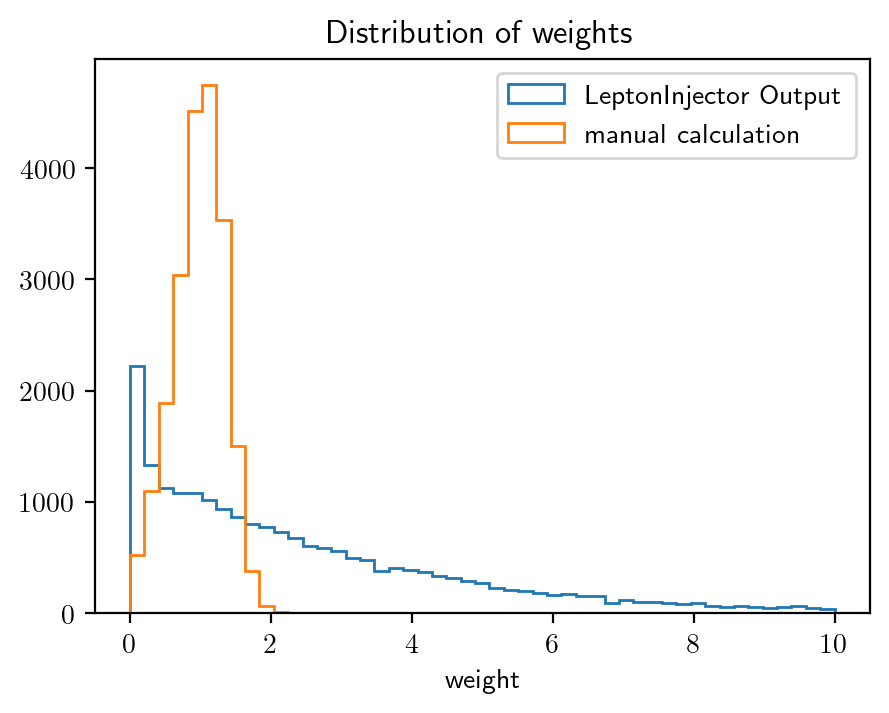

In [181]:
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(5, 3.6), dpi=200)

#bins = np.logspace(np.log10(1e-2), np.log10(1e6), 50)
bins = np.linspace(0, 10, 50)
plt.hist(LI_output_weights, bins=bins, fill=False, histtype='step', label='LeptonInjector Output')
plt.hist(manual_weights, bins=bins, fill=False, histtype='step', label='manual calculation')
#plt.ylim(0,600)
plt.xlabel('weight')
plt.title('Distribution of weights')
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim(0, 10)
plt.legend()

(-1.0, 10.0)

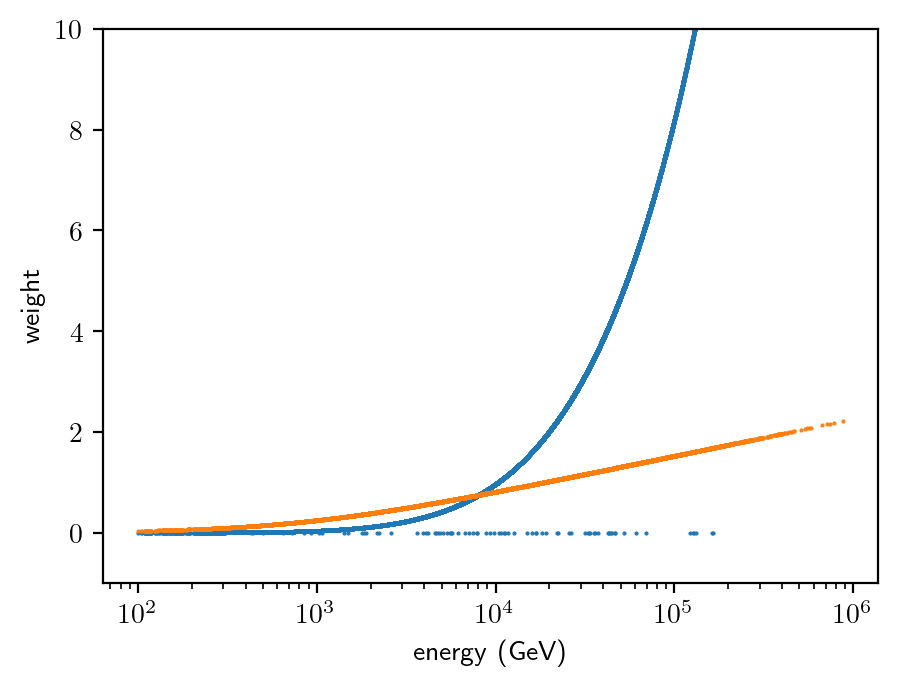

In [189]:
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(5, 3.6), dpi=200)

plt.scatter(LI_output_Enu, LI_output_weights, marker='.', s=1)
plt.scatter(LI_output_Enu, manual_weights, marker='.', s=1)
plt.xscale('log')
plt.xlabel('energy (GeV)')
plt.ylabel('weight')
plt.ylim(-1,10)